# <center> **Uczenie Maszynowe - Praca Zaliczeniowa**

**Pracę wykonał:**
> Michał Sienkiewicz <br>
Inżynieria Danych <br>
Nr indeksu: 134614 <br>
Grupa: 2



**Temat Pracy:** <br>

> *ENTROPIA KRZYŻOWA – rozwiązanie metodą tabelarycznej entropii krzyżowej problemu ze środowiska NChain-v0*



Opis problemu:
Gra przedstawia ruch wzdłuż liniowego łańcucha stanów. <br>
1. Ruch za akcję wsteczną - otrzymujemy małą nagrodę w postaci +2.0 pkt <br>
2. Ruch do przodu nie zwraca żadnej nagrody <br>
3. Zakończenie łańcucha i powrót na początek gwarantuje nam "dużą" nagrodę w postaci +10 punktów. Nagroda może zostać powtórzona poprzez "poślizgnienie się" (szansa 0.2, przejście przeciwne). <br>


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import gym
%matplotlib inline
plt.figure(figsize=(4, 3))

<Figure size 288x216 with 0 Axes>

<Figure size 288x216 with 0 Axes>

In [2]:
env = gym.make("NChain-v0")

In [3]:
env.reset()


0

In [4]:
print("Action space: ", env.action_space)
print("Observation space: ", env.observation_space)

Action space:  Discrete(2)
Observation space:  Discrete(5)


In [5]:
for t in range(200):
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)
  print(t, observation, reward, done)

0 0 2 False
1 0 2 False
2 1 0 False
3 0 2 False
4 1 0 False
5 2 0 False
6 0 2 False
7 0 2 False
8 0 2 False
9 0 2 False
10 1 0 False
11 0 2 False
12 0 2 False
13 0 2 False
14 0 2 False
15 1 0 False
16 2 0 False
17 0 2 False
18 1 0 False
19 0 2 False
20 0 2 False
21 1 0 False
22 0 2 False
23 1 0 False
24 2 0 False
25 3 0 False
26 4 0 False
27 0 2 False
28 0 2 False
29 1 0 False
30 0 2 False
31 1 0 False
32 0 2 False
33 0 2 False
34 1 0 False
35 2 0 False
36 0 2 False
37 1 0 False
38 0 2 False
39 0 2 False
40 0 2 False
41 0 2 False
42 0 2 False
43 0 2 False
44 1 0 False
45 2 0 False
46 3 0 False
47 0 2 False
48 1 0 False
49 2 0 False
50 0 2 False
51 1 0 False
52 0 2 False
53 0 2 False
54 0 2 False
55 1 0 False
56 2 0 False
57 3 0 False
58 4 0 False
59 0 2 False
60 0 2 False
61 1 0 False
62 2 0 False
63 0 2 False
64 1 0 False
65 0 2 False
66 1 0 False
67 2 0 False
68 3 0 False
69 0 2 False
70 1 0 False
71 2 0 False
72 0 2 False
73 1 0 False
74 2 0 False
75 0 2 False
76 1 0 False
77 0 2 Fa

In [6]:
for t in range(199):
  action = env.action_space.sample()
  observation, reward, done, info = env.step(action)


In [7]:
n_states = env.observation_space.n
n_actions = env.action_space.n

In [8]:
def initialize_policy(n_states, n_actions):
  
    policy = np.zeros(shape=(n_states, n_actions)) +  1/n_actions
    
    return policy

policy = initialize_policy(n_states, n_actions)

In [9]:
def generate_session(env, policy, t_max = 1000):
  
  observations, actions = [], []
  total_reward = 0.
  observation = env.reset()
  
  for t in range(t_max):
    
    action = np.random.choice(n_actions, p = policy[observation])

    new_observation, reward, done, info = env.step(action)

    observations.append(observation)
    actions.append(action)
    total_reward += reward

    observation = new_observation
    if done:
        break

  return observations, actions, total_reward

In [10]:
policy.shape

(5, 2)

In [11]:
def select_elites(observations_batch, actions_batch, total_reward_batch, percentile):

    reward_threshold = np.percentile(total_reward_batch, percentile)

    elite_observations = []
    elite_actions = []

    for i in range(len(total_reward_batch)):
      if total_reward_batch[i] >= reward_threshold:
        elite_observations += (observations_batch[i])
        elite_actions += (actions_batch[i])
        
    return elite_observations, elite_actions

In [12]:
def update_policy(elite_observations, elite_actions):

    policy_updated = policy

    elite_observations_unique = set(elite_observations)
    
    actions_count = {observation:[0] * n_actions for observation in elite_observations_unique}

    for observation, action in zip(elite_observations, elite_actions):
        actions_count[observation][action] += 1
        
 
        
    for observation in elite_observations_unique:
        policy_updated[observation] = np.array(actions_count[observation]) / np.sum(actions_count[observation])

    return policy_updated

In [13]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile):

    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    clear_output(True)
    print("mean reward = ", mean_reward)
    print("treshold = ", threshold)
    plt.show()

In [14]:
policy = initialize_policy(n_states, n_actions)

mean reward =  3133.28
treshold =  3132.0


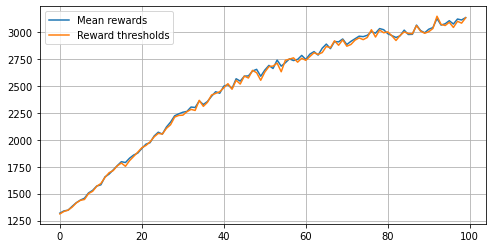

In [15]:
n_sessions = 100
percentile = 50
learning_rate = 0.5

log = []

for i in range(100):
  
    sessions = [generate_session(env, policy, t_max=1000) for j in range(n_sessions)]
    
    observations_batch, actions_batch, total_reward_batch = zip(*sessions)

    elite_observations, elite_actions = select_elites(observations_batch, actions_batch, total_reward_batch, percentile)

    policy_updated = update_policy(elite_observations, elite_actions)

    policy = learning_rate * policy_updated + (1 - learning_rate) * policy

    show_progress(total_reward_batch, log, percentile)

In [16]:
print(policy)

[[0.48170622 0.51829378]
 [0.75526445 0.24473555]
 [0.90875023 0.09124977]
 [0.98496617 0.01503383]
 [0.99519544 0.00480456]]


In [17]:
total_reward = 0.
observation = env.reset()

for t in range(100):

  action = np.random.choice(n_actions, p = policy[observation])
  
  new_observation, reward, done, info = env.step(action)

  observation = new_observation

  total_reward += reward
  
  if done:
    break

  print(t, total_reward, done, action, observation)


0 0.0 False 1 1
1 0.0 False 0 2
2 0.0 False 0 3
3 0.0 False 0 4
4 2.0 False 0 0
5 2.0 False 0 1
6 2.0 False 0 2
7 2.0 False 0 3
8 4.0 False 0 0
9 4.0 False 1 1
10 6.0 False 0 0
11 8.0 False 1 0
12 10.0 False 0 0
13 10.0 False 0 1
14 10.0 False 0 2
15 10.0 False 0 3
16 12.0 False 0 0
17 12.0 False 0 1
18 12.0 False 1 2
19 12.0 False 0 3
20 12.0 False 0 4
21 22.0 False 0 4
22 32.0 False 0 4
23 42.0 False 0 4
24 52.0 False 0 4
25 62.0 False 0 4
26 72.0 False 0 4
27 82.0 False 0 4
28 84.0 False 0 0
29 86.0 False 1 0
30 86.0 False 1 1
31 88.0 False 1 0
32 88.0 False 0 1
33 88.0 False 0 2
34 90.0 False 1 0
35 92.0 False 1 0
36 94.0 False 1 0
37 94.0 False 1 1
38 96.0 False 0 0
39 96.0 False 0 1
40 96.0 False 0 2
41 96.0 False 0 3
42 96.0 False 0 4
43 106.0 False 0 4
44 116.0 False 0 4
45 126.0 False 0 4
46 136.0 False 0 4
47 146.0 False 0 4
48 148.0 False 0 0
49 148.0 False 1 1
50 148.0 False 0 2
51 148.0 False 0 3
52 150.0 False 0 0
53 150.0 False 0 1
54 150.0 False 0 2
55 152.0 False 0 0
5